In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=600,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    nprocs_filter=True,
    nprocs="4_16_48_64_144_240",
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=True,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "SmoothL1Loss_fixed_Adamax_0.2_testSize_new_StandardScaler_2048_batch_0.008_lr_filtered_nprocs_0.05_dropout_pytorch_v1.12.1.tar"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_no_outliers_4_16_48_64_144_240_nprocs"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "Train_Filtered_by_NProcs_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,39775,-1324,-1324,3348398,2023225,3533627,279362,0,1,-1324,...,0.0,0.669968,1513862379,1513910888,48,48510.0,3.1,./SpEC,1,583.031946
1,73579,-699,-699,2632037,41984,1798957,188007,0,1,-699,...,0.0,11.812020,1557000581,1557003025,48,2445.0,3.1,./SpEC,1,274.634615
2,41229,-1263,-1263,5029637,3252692,6031496,299271,0,1,-1263,...,0.0,9.999239,1556921024,1557005236,48,84213.0,3.1,./SpEC,1,188.062253
3,31050,-895,-895,931038,132468,715968,77483,0,1,-895,...,0.0,1.480465,1556914485,1556914695,48,211.0,3.1,./SpEC,1,93.393101
4,4800,-758,-758,211710,133292,201307,15407,0,1,-758,...,0.0,0.767330,1556900615,1556901011,48,397.0,3.1,./SpEC,1,41.003334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,1875,-782,-782,463075,7675,2568,3426,0,0,-782,...,0.0,2.395168,1531626203,1531626256,64,54.0,3.1,pp.x -npool 4 -in Tp-La2CuO4_pp_up.in,1,132.208232
349816,4830,-750,-750,221766,137222,205260,15034,0,1,-750,...,0.0,0.488285,1531501052,1531501561,48,510.0,3.1,./SpEC,1,77.239585
349817,19501,-1414,-1414,4024075,3041091,5769568,174097,0,1,-1414,...,0.0,0.699427,1531484414,1531568987,48,84574.0,3.1,./SpEC,1,327.327635
349818,1875,-782,-782,463075,7675,2568,3426,0,0,-782,...,0.0,1.969952,1531634171,1531634223,64,53.0,3.1,pp.x -npool 4 -in Tp-La2CuO4_pp_up.in,1,130.064385


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,39775,-1324,-1324,3348398,2023225,3533627,279362,0,1,-1324,...,0.0,0.669968,1513862379,1513910888,48,48510.0,3.1,./SpEC,1,583.031946
1,73579,-699,-699,2632037,41984,1798957,188007,0,1,-699,...,0.0,11.812020,1557000581,1557003025,48,2445.0,3.1,./SpEC,1,274.634615
2,41229,-1263,-1263,5029637,3252692,6031496,299271,0,1,-1263,...,0.0,9.999239,1556921024,1557005236,48,84213.0,3.1,./SpEC,1,188.062253
3,31050,-895,-895,931038,132468,715968,77483,0,1,-895,...,0.0,1.480465,1556914485,1556914695,48,211.0,3.1,./SpEC,1,93.393101
4,4800,-758,-758,211710,133292,201307,15407,0,1,-758,...,0.0,0.767330,1556900615,1556901011,48,397.0,3.1,./SpEC,1,41.003334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349815,1875,-782,-782,463075,7675,2568,3426,0,0,-782,...,0.0,2.395168,1531626203,1531626256,64,54.0,3.1,pp.x -npool 4 -in Tp-La2CuO4_pp_up.in,1,132.208232
349816,4830,-750,-750,221766,137222,205260,15034,0,1,-750,...,0.0,0.488285,1531501052,1531501561,48,510.0,3.1,./SpEC,1,77.239585
349817,19501,-1414,-1414,4024075,3041091,5769568,174097,0,1,-1414,...,0.0,0.699427,1531484414,1531568987,48,84574.0,3.1,./SpEC,1,327.327635
349818,1875,-782,-782,463075,7675,2568,3426,0,0,-782,...,0.0,1.969952,1531634171,1531634223,64,53.0,3.1,pp.x -npool 4 -in Tp-La2CuO4_pp_up.in,1,130.064385


In [8]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

0         583.031946
1         274.634615
2         188.062253
3          93.393101
4          41.003334
             ...    
349815    132.208232
349816     77.239585
349817    327.327635
349818    130.064385
349819     32.272505
Name: bandwidth, Length: 349192, dtype: float64

In [9]:
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
config = ConfigStruct(**config)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [12]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index(['exe'], dtype='object')

In [13]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
45931,20164,-1054,-1054,3881828,3307140,5718587,358112,0,1,-1054,...,0.862545,1.615143,0.0,0.488341,1525591150,1525675771,48,84622.0,3.1,1
51777,15334,-1958,-1958,2113588,1513318,2942558,171593,0,1,-1958,...,1.919135,1.271324,0.0,106.766146,1504312833,1504351193,48,38361.0,3.1,1
291614,4648,-703,-703,216444,33229,194123,14011,0,1,-703,...,0.067851,0.296524,0.0,0.613615,1507515023,1507515278,48,256.0,3.1,1
124891,114,-13,-13,45728,10983,76,226,0,0,-13,...,0.017600,0.084076,0.0,0.566300,1570186119,1570186150,16,32.0,3.1,1
341078,3120,-20,-20,138997,25926519,60597,3184,0,0,-20,...,0.081073,1.414850,0.0,124.368863,1562310539,1562311545,64,1007.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295731,4688,-725,-725,222640,35110,195904,14188,0,1,-725,...,0.076455,0.204634,0.0,0.453964,1518382784,1518383128,48,345.0,3.1,1
266200,22550,-1321,-1321,3411638,2191475,4496997,166443,0,1,-1321,...,1.647960,5.531336,0.0,11.278543,1536328838,1536390808,48,61971.0,3.1,1
121626,846,-20,-20,86249,18295101,15380,862,0,0,-20,...,0.057046,0.606483,0.0,131.218645,1568140925,1568141818,16,894.0,3.1,1
87627,9550,-1352,-1352,3724962,3082194,5785195,169606,0,1,-1352,...,0.123357,0.795517,0.0,0.432681,1506235617,1506319338,48,83722.0,3.1,1


In [14]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
202723,14449,-1598,-1598,1123335,685445,1263548,146173,0,1,-1598,...,0.408523,2.209390,0.0,0.576212,1504909677,1504925699,48,16023.0,3.1,1
89952,19699,-2454,-2454,623602,215466,744798,55277,0,1,-2454,...,0.085554,1.770115,0.0,0.393055,1555924441,1555926484,144,2044.0,3.1,1
31234,8016,-938,-938,1372561,1208844,1901400,107254,0,1,-938,...,0.224603,0.329138,0.0,0.391217,1506781558,1506810443,48,28886.0,3.1,1
107709,76754,-608,-608,2681532,24497,1885840,198703,0,1,-608,...,0.109544,0.324660,0.0,3.129030,1509085079,1509087085,48,2007.0,3.1,1
1990,820,-20,-20,114422,38732023,15610,836,0,0,-20,...,0.110299,0.859565,0.0,188.442922,1568132960,1568135881,16,2922.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192518,4831,-778,-778,346241,246674,344145,23489,0,1,-778,...,0.907250,1.051526,0.0,0.754595,1536497516,1536502193,48,4678.0,3.1,1
167479,114,-13,-13,45728,10983,76,226,0,0,-13,...,0.023988,0.059391,0.0,0.336710,1569569537,1569569570,16,34.0,3.1,1
191236,24207,-890,-890,3634375,3682553,4901412,576616,0,1,-890,...,1.073884,0.930748,0.0,0.500282,1534030646,1534093792,48,63147.0,3.1,1
28017,26386,-983,-983,526648,273554,513376,63064,0,1,-983,...,0.189423,0.559837,0.0,0.357170,1511851895,1511855144,64,3250.0,3.1,1


In [15]:
scaler = StandardScaler().fit(X_train)

In [16]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 2.93320348e-01, -5.86339321e-01, -5.86339321e-01, ...,
         1.86571309e+00,  1.77635684e-15,  1.08694096e-02],
       [ 8.42299074e-02, -1.90693517e+00, -1.90693517e+00, ...,
         4.63565259e-01,  1.77635684e-15,  1.08694096e-02],
       [-3.78366458e-01, -7.35858420e-02, -7.35858420e-02, ...,
        -6.91378279e-01,  1.77635684e-15,  1.08694096e-02],
       ...,
       [-5.42954833e-01,  9.24165229e-01,  9.24165229e-01, ...,
        -6.72040818e-01,  1.77635684e-15,  1.08694096e-02],
       [-1.66159141e-01, -1.02166848e+00, -1.02166848e+00, ...,
         1.83843454e+00,  1.77635684e-15,  1.08694096e-02],
       [-5.74686364e-01,  9.34391082e-01,  9.34391082e-01, ...,
        -6.97682655e-01,  1.77635684e-15,  1.08694096e-02]],
      shape=(279353, 102))

In [17]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[ 2.9332e-01, -5.8634e-01, -5.8634e-01,  ...,  1.8657e+00,
          1.7764e-15,  1.0869e-02],
        [ 8.4230e-02, -1.9069e+00, -1.9069e+00,  ...,  4.6357e-01,
          1.7764e-15,  1.0869e-02],
        [-3.7837e-01, -7.3586e-02, -7.3586e-02,  ..., -6.9138e-01,
          1.7764e-15,  1.0869e-02],
        ...,
        [-5.4295e-01,  9.2417e-01,  9.2417e-01,  ..., -6.7204e-01,
          1.7764e-15,  1.0869e-02],
        [-1.6616e-01, -1.0217e+00, -1.0217e+00,  ...,  1.8384e+00,
          1.7764e-15,  1.0869e-02],
        [-5.7469e-01,  9.3439e-01,  9.3439e-01,  ..., -6.9768e-01,
          1.7764e-15,  1.0869e-02]], device='cuda:0')

In [18]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)
tensor_y_train

tensor([[ 51.1503],
        [  7.8923],
        [ 55.5303],
        ...,
        [ 18.2051],
        [107.6904],
        [ 71.9506]], device='cuda:0')

In [19]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [20]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 4.59183050e-02, -1.38103417e+00, -1.38103417e+00, ...,
        -2.13488376e-01,  1.77635684e-15,  1.08694096e-02],
       [ 2.73190523e-01, -2.63150989e+00, -2.63150989e+00, ...,
        -6.37184891e-01,  1.77635684e-15,  1.08694096e-02],
       [-2.32565919e-01, -4.16882331e-01, -4.16882331e-01, ...,
         1.76382736e-01,  1.77635684e-15,  1.08694096e-02],
       ...,
       [ 4.68341600e-01, -3.46762197e-01, -3.46762197e-01, ...,
         1.21481655e+00,  1.77635684e-15,  1.08694096e-02],
       [ 5.62670393e-01, -4.82619956e-01, -4.82619956e-01, ...,
        -6.00631633e-01,  1.77635684e-15,  1.08694096e-02],
       [-4.44167176e-01,  9.24165229e-01,  9.24165229e-01, ...,
        -6.77557147e-01,  1.77635684e-15,  1.08694096e-02]],
      shape=(69839, 102))

In [21]:
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[ 4.5918e-02, -1.3810e+00, -1.3810e+00,  ..., -2.1349e-01,
          1.7764e-15,  1.0869e-02],
        [ 2.7319e-01, -2.6315e+00, -2.6315e+00,  ..., -6.3718e-01,
          1.7764e-15,  1.0869e-02],
        [-2.3257e-01, -4.1688e-01, -4.1688e-01,  ...,  1.7638e-01,
          1.7764e-15,  1.0869e-02],
        ...,
        [ 4.6834e-01, -3.4676e-01, -3.4676e-01,  ...,  1.2148e+00,
          1.7764e-15,  1.0869e-02],
        [ 5.6267e-01, -4.8262e-01, -4.8262e-01,  ..., -6.0063e-01,
          1.7764e-15,  1.0869e-02],
        [-4.4417e-01,  9.2417e-01,  9.2417e-01,  ..., -6.7756e-01,
          1.7764e-15,  1.0869e-02]], device='cuda:0')

In [22]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)
tensor_y_test

tensor([[130.2770],
        [197.6645],
        [120.9669],
        ...,
        [ 39.7272],
        [254.4669],
        [ 23.0480]], device='cuda:0')

In [23]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [24]:
model = nn.Sequential(
    nn.Linear(102, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [25]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [26]:
model_epoch = 0

In [27]:
if Path(MODEL_PATH).is_file():
    print("Loading pretrained model...")

    checkpoint = torch.load(MODEL_PATH, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    model_epoch = checkpoint['epoch']

    print(f"Current epoch: {model_epoch}")

model.train()

Sequential(
  (0): Linear(in_features=102, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [29]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [30]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

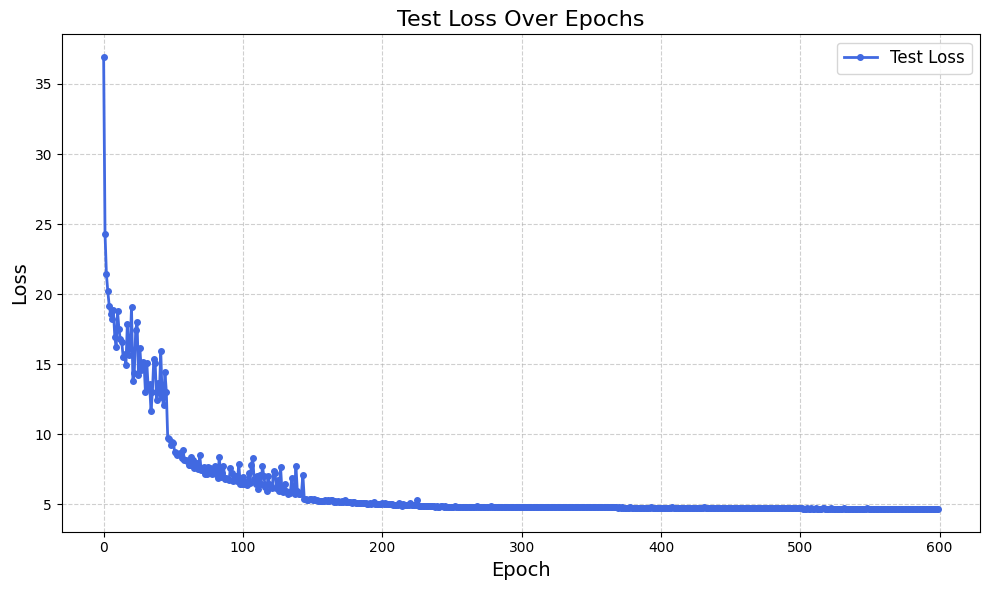

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()